Importing plotly failed. Interactive plots will not work.


Dataset head:
        date       revenue       calls  activations   returns
0 2023-01-01  20745.071230  718.818330     8.021117  1.513636
1 2023-01-02  19867.253265  677.777610     5.498305  3.442261
2 2023-01-03  21120.789990  730.580855     8.030269  5.192428
3 2023-01-04  22508.324961  716.114827     7.302289  2.013075
4 2023-01-05  19946.946479  719.522042     6.817732  3.181748


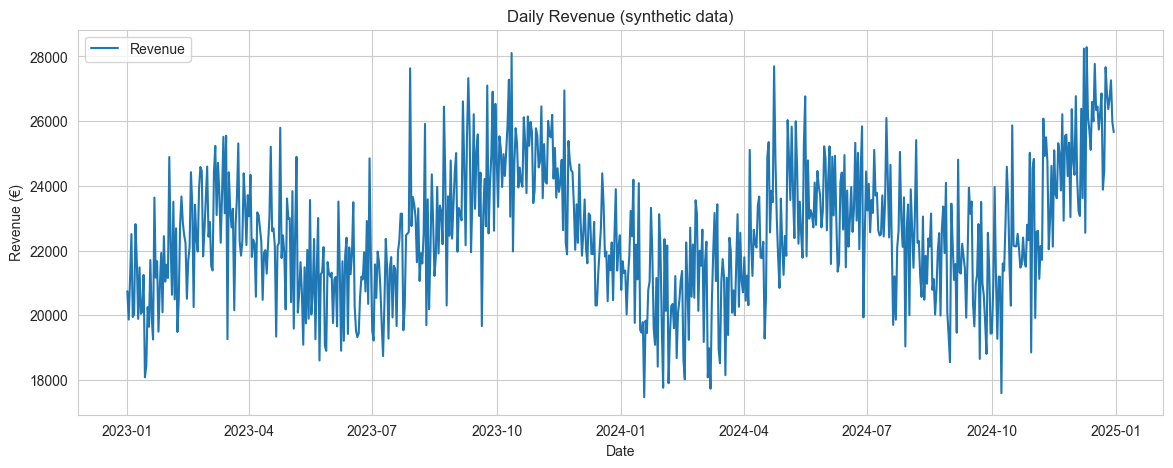

Train size: 620, Test size: 110
ARIMA RMSE: 2972.41


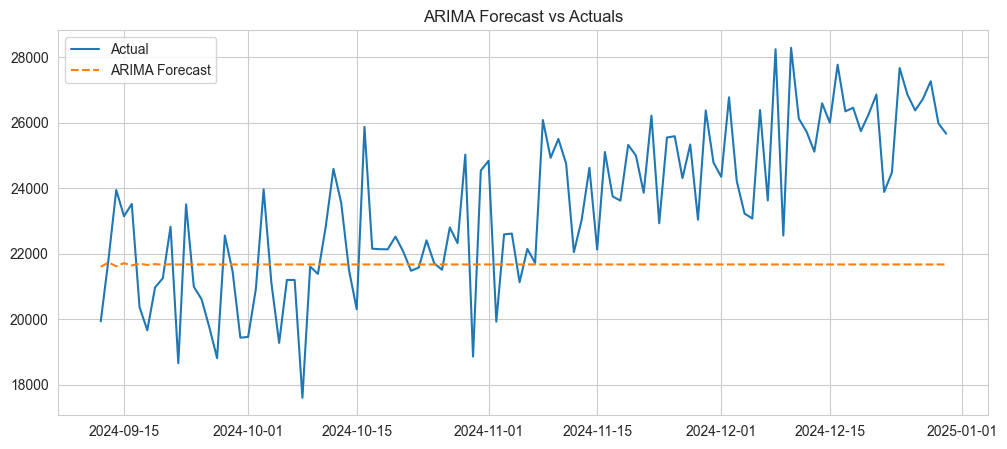

11:13:25 - cmdstanpy - INFO - Chain [1] start processing
11:13:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 3711.76


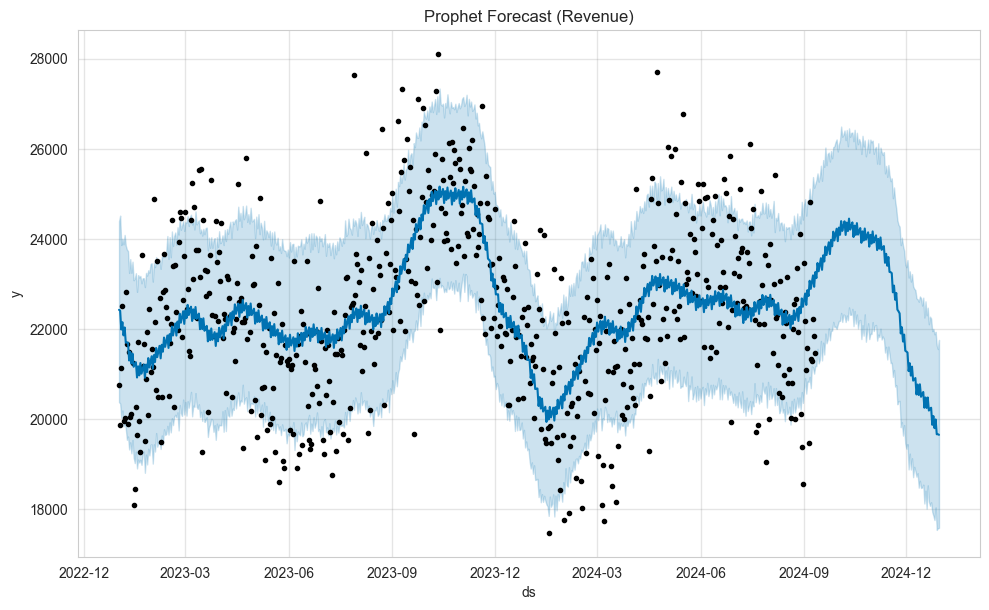

XGBoost RMSE: 884.06 | R²: 0.863


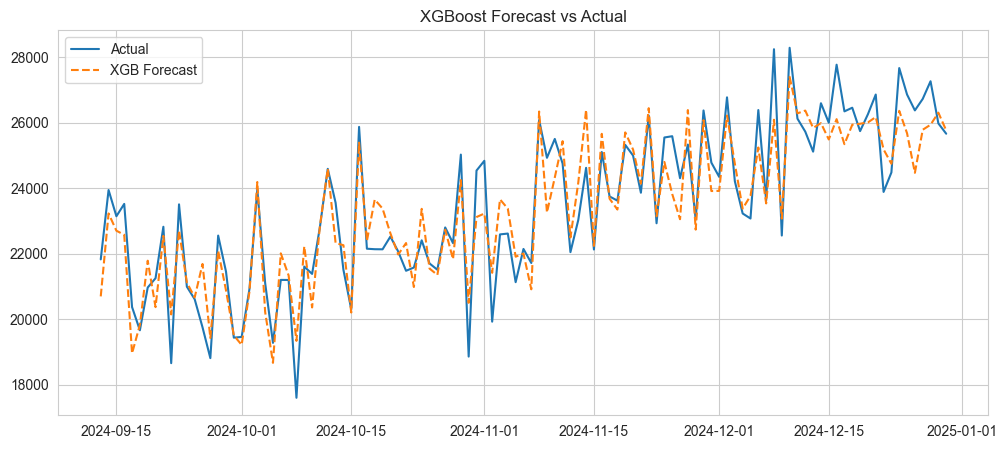


Model comparison:
     Model         RMSE
2  XGBoost   884.058696
0    ARIMA  2972.408045
1  Prophet  3711.758505


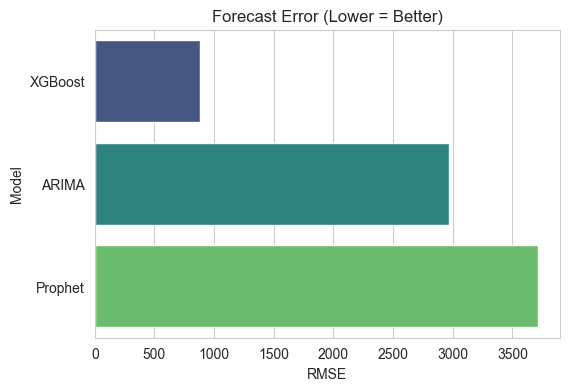

ValueError: operands could not be broadcast together with shapes (110,) (109,) 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

sns.set_style("whitegrid")
np.random.seed(42)


n_days = 730  # ~2 years
start_date = datetime(2023, 1, 1)

dates = pd.date_range(start_date, periods=n_days, freq="D")
base_revenue = 20000 + 2000 * np.sin(np.linspace(0, 20, n_days))
trend = np.linspace(0, 5000, n_days)
seasonal = 1500 * np.sin(np.linspace(0, 2*np.pi, n_days))  # yearly
random_noise = np.random.normal(0, 1500, n_days)

revenue = base_revenue + trend + seasonal + random_noise

calls = 300 + 0.02 * revenue + np.random.normal(0, 20, n_days)
activations = 0.04 * revenue / 100 + np.random.normal(0, 2, n_days)
returns = np.maximum(0, 0.015 * revenue / 100 + np.random.normal(0, 1, n_days))

df = pd.DataFrame({
    "date": dates,
    "revenue": revenue,
    "calls": calls,
    "activations": activations,
    "returns": returns
})

print("Dataset head:")
print(df.head())

plt.figure(figsize=(14, 5))
plt.plot(df["date"], df["revenue"], label="Revenue")
plt.title("Daily Revenue (synthetic data)")
plt.xlabel("Date")
plt.ylabel("Revenue (€)")
plt.legend()
plt.show()

split_idx = int(len(df) * 0.85)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]
print(f"Train size: {len(train)}, Test size: {len(test)}")
model_arima = ARIMA(train["revenue"], order=(3,1,2))
fitted_arima = model_arima.fit()
arima_pred = fitted_arima.forecast(steps=len(test))

arima_rmse = np.sqrt(mean_squared_error(test["revenue"], arima_pred))
print(f"ARIMA RMSE: {arima_rmse:.2f}")

plt.figure(figsize=(12,5))
plt.plot(test["date"], test["revenue"], label="Actual")
plt.plot(test["date"], arima_pred, label="ARIMA Forecast", linestyle="--")
plt.title("ARIMA Forecast vs Actuals")
plt.legend()
plt.show()

df_prophet = df[["date", "revenue"]].rename(columns={"date": "ds", "revenue": "y"})
train_prophet = df_prophet.iloc[:split_idx]
test_prophet = df_prophet.iloc[split_idx:]

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(train_prophet)
future = m.make_future_dataframe(periods=len(test_prophet))
forecast = m.predict(future)

prophet_pred = forecast["yhat"].iloc[-len(test):].values
prophet_rmse = np.sqrt(mean_squared_error(test["revenue"], prophet_pred))
print(f"Prophet RMSE: {prophet_rmse:.2f}")

# optional plot
fig = m.plot(forecast)
plt.title("Prophet Forecast (Revenue)")
plt.show()

# feature engineering
df["month"] = df["date"].dt.month
df["dayofweek"] = df["date"].dt.dayofweek
df["lag1"] = df["revenue"].shift(1)
df["lag7"] = df["revenue"].shift(7)
df["rolling7"] = df["revenue"].rolling(7, min_periods=1).mean()
df = df.dropna()

split_idx = int(len(df) * 0.85)
X_cols = ["month", "dayofweek", "lag1", "lag7", "rolling7", "calls", "activations", "returns"]
X_train, X_test = df[X_cols].iloc[:split_idx], df[X_cols].iloc[split_idx:]
y_train, y_test = df["revenue"].iloc[:split_idx], df["revenue"].iloc[split_idx:]

xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    random_state=42,
    verbosity=0
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {xgb_rmse:.2f} | R²: {xgb_r2:.3f}")

plt.figure(figsize=(12,5))
plt.plot(df["date"].iloc[split_idx:], y_test.values, label="Actual")
plt.plot(df["date"].iloc[split_idx:], y_pred_xgb, label="XGB Forecast", linestyle="--")
plt.legend()
plt.title("XGBoost Forecast vs Actual")
plt.show()


results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "XGBoost"],
    "RMSE": [arima_rmse, prophet_rmse, xgb_rmse]
}).sort_values("RMSE")

print("\nModel comparison:")
print(results)

plt.figure(figsize=(6,4))
sns.barplot(data=results, x="RMSE", y="Model", palette="viridis")
plt.title("Forecast Error (Lower = Better)")
plt.show()

# quick average ensemble (simple blending)
ensemble_pred = (arima_pred.values + prophet_pred + y_pred_xgb[:len(arima_pred)]) / 3
ensemble_rmse = np.sqrt(mean_squared_error(test["revenue"].values, ensemble_pred))
print(f"Ensemble RMSE: {ensemble_rmse:.2f}")

plt.figure(figsize=(12,5))
plt.plot(test["date"], test["revenue"], label="Actual")
plt.plot(test["date"], ensemble_pred, label="Ensemble Forecast", linestyle="--")
plt.title("Ensemble Forecast vs Actual")
plt.legend()
plt.show()